<a href="https://colab.research.google.com/github/RyanXJu/Airbnb_Montreal/blob/master/PricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Airbnb price in Montreal

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import scipy

In [4]:
# load listing datasets
root_path = 'gdrive/My Drive/Airbnb/'
listings_detail = pd.read_csv(root_path+"listings_detail.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
listings_detail.head(10)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2078,https://www.airbnb.com/rooms/2078,20200113202958,2020-01-14,Central comfy close to Metro Laurie,Centrally located in trendy Le Plateau. Join...,Centrally located clean comfy furnished room ...,Centrally located in trendy Le Plateau. Join...,none,Although my place is centrally located in Le P...,I always inform my guests the places/attractio...,I am 6-8 mins. walk to Metro Laurie and bus ro...,You will have full access in the apartment. I...,I am always available to help and give informa...,No house rules but I expect my guests to follo...,NaN,NaN,https://a0.muscache.com/im/pictures/88170231/0...,NaN,2277,https://www.airbnb.com/users/show/2277,Nelia,2008-08-19,"Montreal, Québec, Canada","Honest, quiet and adhere to the golden rules a...",within a few hours,100%,NaN,f,https://a0.muscache.com/im/users/2277/profile_...,https://a0.muscache.com/im/users/2277/profile_...,Le Plateau,1.0,1.0,"['email', 'phone', 'reviews', 'manual_offline'...",t,t,"Montreal, QC, Canada",Le Plateau-Mont-Royal,Le Plateau-Mont-Royal,...,$6.00,2,7,2,2,7,7,2.0,7.0,7 weeks ago,t,0,0,0,226,2020-01-14,245,0,2011-09-06,2018-09-23,93.0,10.0,9.0,10.0,10.0,10.0,10.0,f,NaN,"{Quebec,"" CA""}",t,f,flexible,f,f,1,0,1,0,2.41
1,2843,https://www.airbnb.com/rooms/2843,20200113202958,2020-01-14,Fabulous downtown/airport room,Come stay in this trendy area of downtown Mont...,"Private individual room in the downtown area, ...",Come stay in this trendy area of downtown Mont...,none,This area of St Henri is actually downtown Mon...,From this room you can walk to downtown Montre...,There is a major metro/subway stop called Lion...,"The guests can use the kitchen anytime, fully ...",I meet guests when they arrive show them the h...,No smoking and no pets Airport bus stops acros...,NaN,NaN,https://a0.muscache.com/im/pictures/803776/a2a...,NaN,2319,https://www.airbnb.com/users/show/2319,Gail,2008-08-19,"Montreal, Québec, Canada",Manage a network of downtown rooms and private...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/7c04e...,https://a0.muscache.com/im/pictures/user/7c04e...,Little Burgundy,6.0,6.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,t,"Montréal, Québec, Canada",Le Sud-Ouest,Le Sud-Ouest,...,$10.00,1,365,1,1,365,365,1.0,365.0,3 days ago,t,18,18,18,18,2020-01-14,143,30,2009-06-20,2019-12-30,88.0,9.0,9.0,9.0,9.0,10.0,10.0,f,NaN,"{Quebec,"" CA""}",t,f,moderate,f,f,5,2,3,0,1.11
2,14584,https://www.airbnb.com/rooms/14584,20200113202958,2020-01-14,"Spread Out in 1,200 Square Feet of Luxury in t...",This stylish and spaciou

In [20]:
listings_detail.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20466 entries, 0 to 20465
Data columns (total 106 columns):
id                                              20466 non-null int64
listing_url                                     20466 non-null object
scrape_id                                       20466 non-null int64
last_scraped                                    20466 non-null object
name                                            20448 non-null object
summary                                         19503 non-null object
space                                           13659 non-null object
description                                     19916 non-null object
experiences_offered                             20466 non-null object
neighborhood_overview                           12631 non-null object
notes                                           7255 non-null object
transit                                         12668 non-null object
access                                          10081

### select features

In [44]:
## neighbourhood,
## amenities, need to separate to tokens
df = listings_detail.loc[:, ["host_response_time",
                               "host_response_rate",
                               "host_is_superhost",
                               "host_identity_verified",
                               "latitude",
                               "longitude",
                               "is_location_exact",
                               "property_type",
                               "room_type",
                               "accommodates",
                               "bathrooms",
                               "bedrooms",
                               "beds",
                               "bed_type",
                             "number_of_reviews",
                             "review_scores_rating",
                               "price"]]
df.head(3)

,host_response_time,host_response_rate,host_is_superhost,host_identity_verified,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,number_of_reviews,review_scores_rating,price
0,within a few hours,100%,f,t,45.53069,-73.58588,t,House,Private room,2,1.0,1.0,1.0,Real Bed,245,93.0,$39.00
1,within an hour,100%,f,t,45.48442,-73.57923,t,Apartment,Private room,2,1.0,1.0,1.0,Real Bed,143,88.0,$30.00
2,within a few hours,100%,t,t,45.54135,-73.57814,f,Loft,Entire home/apt,4,1.0,1.0,1.0,Real Bed,171,98.0,$175.00


In [45]:
df.price = pd.to_numeric(df.price.str.replace(r"$","").str.replace(r",",""))
df.price.describe()

count    20466.000000
mean       112.971269
std        222.295173
min         10.000000
25%         50.000000
50%         80.000000
75%        120.000000
max      13294.000000
Name: price, dtype: float64

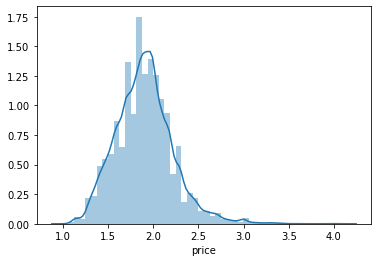

In [46]:
sns.distplot(np.log10(df.price))

In [47]:
# check samples with price > 1500
df.loc[df.price>1500, :].shape

(46, 17)

In [49]:
df.info(verbose = True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20466 entries, 0 to 20465
Data columns (total 17 columns):
host_response_time        12098 non-null object
host_response_rate        12098 non-null object
host_is_superhost         20429 non-null object
host_identity_verified    20429 non-null object
latitude                  20466 non-null float64
longitude                 20466 non-null float64
is_location_exact         20466 non-null object
property_type             20466 non-null object
room_type                 20466 non-null object
accommodates              20466 non-null int64
bathrooms                 20438 non-null float64
bedrooms                  20435 non-null float64
beds                      20374 non-null float64
bed_type                  20466 non-null object
number_of_reviews         20466 non-null int64
review_scores_rating      16139 non-null float64
price                     20466 non-null float64
dtypes: float64(7), int64(2), object(8)
memory usage: 2.7+ MB


In [26]:
for col in df:
    if(df[col].isnull().any()):
        print(col)


host_response_time
host_response_rate
host_is_superhost
host_identity_verified
bathrooms
bedrooms
beds


# verify preselected features

(array([1979.,    0., 8432.,    0.,    0., 1375.,    0., 8368.,    0.,
         312.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

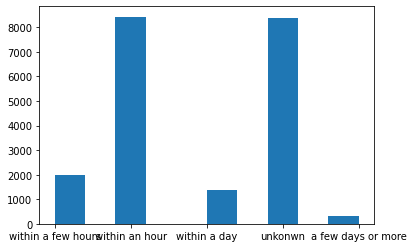

In [27]:
np.unique(df.host_response_time.fillna("unkonwn"))
plt.hist(df.host_response_time.fillna("unkonwn"))

(array([1.8166e+04, 4.6400e+02, 2.7400e+02, 1.5900e+02, 2.6100e+02,
        7.8200e+02, 1.9000e+02, 5.6000e+01, 9.8000e+01, 1.6000e+01]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

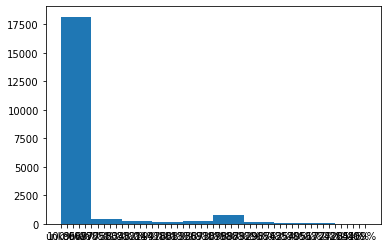

In [14]:
np.unique(df.host_response_rate.fillna("unkonwn"))
plt.hist(df.host_response_rate.fillna("unkonwn"))

(array([16463.,     0.,     0.,     0.,     0.,  3966.,     0.,     0.,
            0.,    37.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

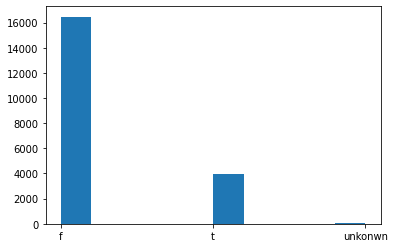

In [15]:
np.unique(df.host_is_superhost.fillna("unkonwn"))
plt.hist(df.host_is_superhost.fillna("unkonwn"))

(array([ 6685.,     0.,     0.,     0.,     0., 13744.,     0.,     0.,
            0.,    37.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

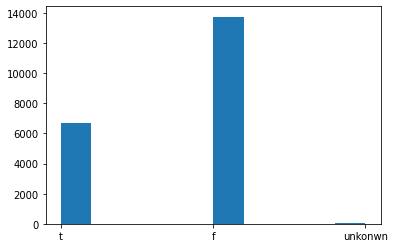

In [73]:
np.unique(df.host_identity_verified.fillna("unkonwn"))
plt.hist(df.host_identity_verified.fillna("unkonwn"))

(array([1.8528e+04, 1.8510e+03, 5.5000e+01, 1.0000e+01, 1.8000e+01,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

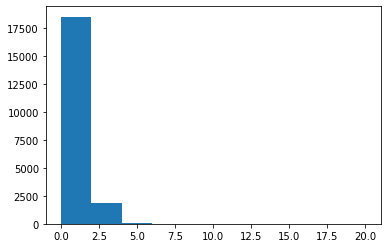

In [77]:
np.unique(df.bathrooms.fillna(0))
plt.hist(df.bathrooms.fillna(0))

(array([1.3918e+04, 5.7810e+03, 6.4100e+02, 8.7000e+01, 2.5000e+01,
        5.0000e+00, 5.0000e+00, 1.0000e+00, 1.0000e+00, 2.0000e+00]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

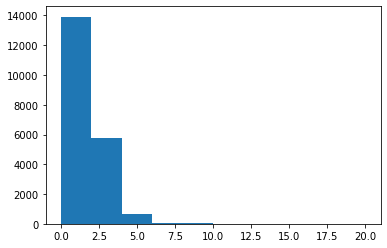

In [78]:
np.unique(df.bedrooms.fillna(0))
plt.hist(df.bedrooms.fillna(0))

(array([1.9616e+04, 7.6200e+02, 6.3000e+01, 1.4000e+01, 9.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 0.,  5., 10., 15., 20., 25., 30., 35., 40., 45., 50.]),
 <a list of 10 Patch objects>)

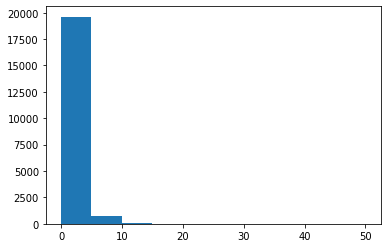

In [79]:
np.unique(df.beds.fillna(0))
plt.hist(df.beds.fillna(0))

# Select features for linear model


In [0]:
# keep only binary features and numeric features

# host_is_superhost         20383 non-null object
# host_identity_verified    20383 non-null object
# latitude                  20420 non-null float64
# longitude                 20420 non-null float64
# accommodates              20420 non-null int64
# bathrooms                 20392 non-null float64
# bedrooms                  20389 non-null float64
# beds                      20328 non-null float64
# number_of_reviews         20466 non-null int64
# review_scores_rating      16139 non-null float64
# price                     20420 non-null float64

neighbourhood             20316 non-null object
property_type             20466 non-null object
room_type                 20466 non-null object
bed_type                  20466 non-null object


# remove samples with price > 1500$
data = df.loc[:,["host_is_superhost",
                 "host_identity_verified",
                 "latitude",
                 "longitude",
                 "accommodates",
                 "bathrooms",
                 "bedrooms",
                 "beds",
                 "number_of_reviews",
                 "review_scores_rating",
                 "price"]]

### deal with missing value and non-numeric values

In [70]:
data.fillna(0, inplace=True) 
data = data.replace("f", 0).replace("t", 1)
data.head()

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,price
0,0.0,1.0,45.53069,-73.58588,2,1.0,1.0,1.0,245,93.0,39.0
1,0.0,1.0,45.48442,-73.57923,2,1.0,1.0,1.0,143,88.0,30.0
2,1.0,1.0,45.54135,-73.57814,4,1.0,1.0,1.0,171,98.0,175.0
3,1.0,1.0,45.51888,-73.56546,4,1.0,1.0,2.0,319,94.0,81.0
4,1.0,1.0,45.52020,-73.56422,5,1.0,2.0,2.0,65,92.0,145.0


# split training and testing data

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1], 
                                                    data.iloc[:,-1], 
                                                    test_size = 0.3, 
                                                    random_state = 100)

In [76]:
X_train.describe()

,host_is_superhost,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating
count,14326.000000,14326.000000,14326.000000,14326.000000,14326.000000,14326.000000,14326.000000,14326.000000,14326.000000,14326.000000
mean,0.197124,0.326958,45.515958,-73.589375,3.532877,1.147878,1.411280,1.824375,23.253455,73.901578
std,0.397841,0.469118,0.031712,0.042790,2.419698,0.513073,1.036666,1.459593,45.029345,38.918576
min,0.000000,0.000000,45.404540,-73.964380,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,45.497380,-73.603025,2.000000,1.000000,1.000000,1.000000,1.000000,80.000000
50%,0.000000,0.000000,45.519170,-73.579765,3.000000,1.000000,1.000000,1.000000,6.000000,94.000000
75%,0.000000,1.000000,45.533880,-73.566122,4.000000,1.000000,2.000000,2.000000,24.000000,99.000000
max,1.000000,1.000000,45.700200,-73.480770,48.000000,20.000000,20.000000,32.000000,523.000000,100.000000


[[1.         0.57886013]
 [0.57886013 1.        ]]


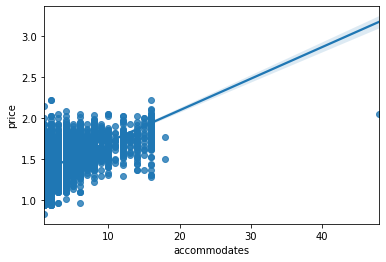

In [104]:
sns.regplot(x=X_train.accommodates,
            y=np.log(np.log(y_train)),fit_reg=True)
print (np.corrcoef(X_train.accommodates, np.log((y_train))))

[[1.         0.24712318]
 [0.24712318 1.        ]]


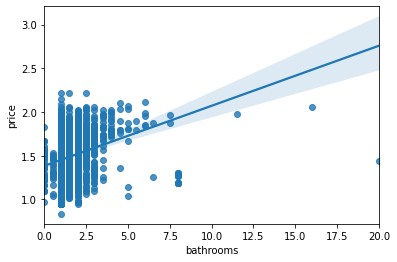

In [105]:
sns.regplot(x=X_train.bathrooms,
            y=np.log(np.log(y_train)),fit_reg=True)
print (np.corrcoef(X_train.bathrooms, np.log((y_train))))

[[1.         0.48444048]
 [0.48444048 1.        ]]


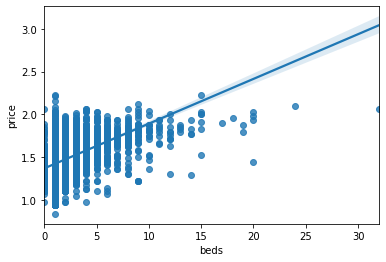

In [106]:
sns.regplot(x=X_train.beds,
            y=np.log(np.log(y_train)),fit_reg=True)
print (np.corrcoef(X_train.beds, np.log((y_train))))

In [118]:
X_train[['room_type', 'price']].groupby(['room_type'], as_index=False).mean().sort_values(by='price',ascending=False)

KeyError: ignored

In [119]:
X_train.columns

Index(['host_is_superhost', 'host_identity_verified', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'number_of_reviews',
       'review_scores_rating'],
      dtype='object')

## Linear regression

In [0]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [113]:
# R^2
reg.score(X_train, y_train)

0.14836451350157231

In [0]:
# predict on testing data
y_pred = reg.predict(X_test)

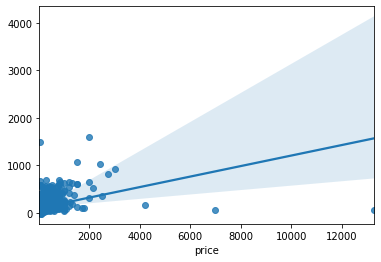

In [116]:
sns.regplot(x=y_test,y=y_pred,fit_reg=True)

In [0]:
from sklearn.metrics import mean_squared_error